In [26]:
!pip install plotly dash prophet statsmodels scikit-learn tensorflow

  Using cached dash-2.17.1-py3-none-any.whl (7.5 MB)
  Using cached dash_html_components-2.0.0-py3-none-any.whl (4.1 kB)
  Using cached dash_core_components-2.0.0-py3-none-any.whl (3.8 kB)
  Using cached dash_table-5.0.0-py3-none-any.whl (3.9 kB)
  Using cached retrying-1.3.4-py3-none-any.whl (11 kB)


In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
from dash import Dash, dcc, html, Input, Output
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import mean_squared_error
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.metrics import mean_squared_error, mean_absolute_error

# import warnings
# warnings.filterwarnings("ignore")

In [8]:
#American Electric Power (AEP)
#estimated energy consumption in Megawatts (MW)

aep = pd.read_csv('data/AEP_hourly.csv', index_col=[0], parse_dates=[0])
aep = aep.rename(columns={'AEP_MW': 'y'})
aep.reset_index(inplace=True)
aep = aep.rename(columns={'Datetime': 'ds'})

aep.head()

,ds,y
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [9]:
# Split data into train and test
train_size = int(len(aep) * 0.8)
train, test = aep[:train_size], aep[train_size:]

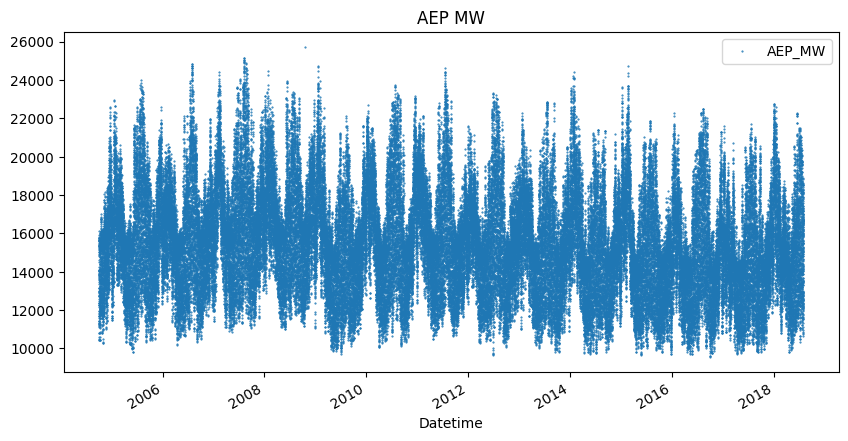

In [3]:
color_pal = sns.color_palette()
aep.plot(style='.',figsize=(10, 5),ms=1,color=color_pal[0],title='AEP MW')
plt.show()

In [4]:
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

In [10]:
# Prophet
def prophet_forecast(train, test):
    model = Prophet()
    model.fit(train)
    future = model.make_future_dataframe(periods=len(test), freq='H')
    forecast = model.predict(future)
    forecast = forecast['yhat'].iloc[-len(test):].values
    return forecast

In [11]:
# ARIMA
def arima_forecast(train, test):
    model = ARIMA(train['y'], order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    return forecast

In [12]:
# XGBoost
def xgboost_forecast(train, test):
    train_X = np.arange(len(train)).reshape(-1, 1)
    test_X = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
    model = GradientBoostingRegressor()
    model.fit(train_X, train['y'])
    forecast = model.predict(test_X)
    return forecast

In [ ]:
def lstm_forecast(train, test, epochs=20, batch_size=32):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train['y'].values.reshape(-1, 1))

    def create_dataset(data, look_back=1):
        X, y = [], []
        for i in range(len(data) - look_back):
            a = data[i:(i + look_back), 0]
            X.append(a)
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 3
    train_X, train_y = create_dataset(train_scaled, look_back)
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))

    model = Sequential()
    model.add(LSTM(30, input_shape=(1, look_back)))  # Reduced number of LSTM units
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, verbose=1)

    test_scaled = scaler.transform(test['y'].values.reshape(-1, 1))
    test_X, _ = create_dataset(np.concatenate((train_scaled[-look_back:], test_scaled), axis=0), look_back)
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

    forecast = model.predict(test_X)
    forecast = scaler.inverse_transform(forecast)
    return forecast.flatten()

In [15]:
# Forecasts
prophet_pred = prophet_forecast(train, test)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3yvirkhb/wqlynzm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3yvirkhb/3i_6skn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53402', 'data', 'file=/tmp/tmp3yvirkhb/wqlynzm3.json', 'init=/tmp/tmp3yvirkhb/3i_6skn5.json', 'output', 'file=/tmp/tmp3yvirkhb/prophet_modelv1_zzrel/prophet_model-20240715132500.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:25:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:26:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [16]:
# Forecasts
arima_pred = arima_forecast(train, test)

In [17]:
# Forecasts
xgboost_pred = xgboost_forecast(train, test)

In [ ]:
# Forecasts
lstm_pred = lstm_forecast(train, test)

In [18]:
prophet_rmse = calculate_rmse(test['y'], prophet_pred)
arima_rmse = calculate_rmse(test['y'], arima_pred)
xgboost_rmse = calculate_rmse(test['y'], xgboost_pred)
lstm_rmse = calculate_rmse(test['y'], lstm_pred)

In [19]:
# RMSE
print(f"Prophet RMSE: {prophet_rmse:.4f}")
print(f"ARIMA RMSE: {arima_rmse:.4f}")
print(f"XGBoost RMSE: {xgboost_rmse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")

Prophet RMSE: 3393.0133
ARIMA RMSE: 4300.5740
XGBoost RMSE: 2718.1649


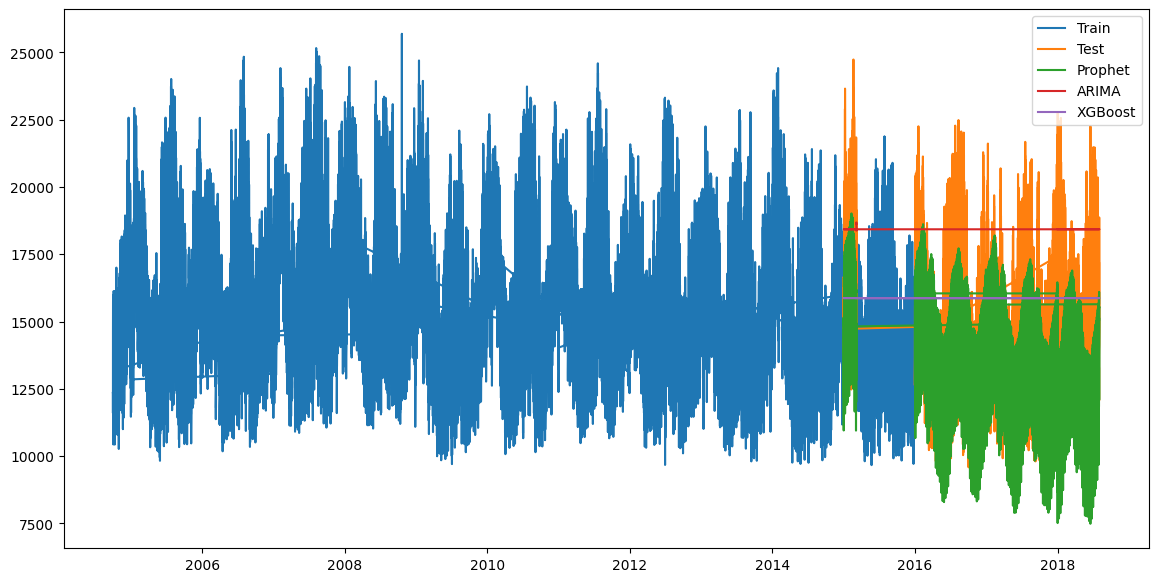

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(train['ds'], train['y'], label='Train')
plt.plot(test['ds'], test['y'], label='Test')
plt.plot(test['ds'], prophet_pred, label='Prophet')
plt.plot(test['ds'], arima_pred, label='ARIMA')
plt.plot(test['ds'], xgboost_pred, label='XGBoost')
plt.plot(test['ds'], lstm_pred, label='LSTM')
plt.legend()
plt.show()

In [21]:
def plot_forecast(model_name):
    if model_name == 'Prophet':
        forecast = prophet_pred
        rmse = prophet_rmse
    elif model_name == 'ARIMA':
        forecast = arima_pred
        rmse = arima_rmse
    elif model_name == 'XGBoost':
        forecast = xgboost_pred
        rmse = xgboost_rmse
    # else:
    #     forecast = lstm_pred
    #     rmse = lstm_rmse

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=test['ds'], y=forecast, mode='lines', name=f'{model_name} Forecast'))

    fig.update_layout(
        title=f'{model_name} Forecast vs Actuals',
        xaxis_title='Date',
        yaxis_title='AEP_MW',
        legend_title='Series'
    )

    fig.show()

    print(f'RMSE for {model_name}: {rmse:.4f}')


interact(plot_forecast, model_name=widgets.Dropdown(
    options=['Prophet', 'ARIMA', 'XGBoost'],
    #, 'LSTM'],
    value='Prophet',
    description='Model:',
    disabled=False,
))

def plot_forecast(model_name):
    if model_name == 'Prophet':
        forecast = prophet_pred
        rmse = prophet_rmse
    elif model_name == 'ARIMA':
        forecast = arima_pred
        rmse = arima_rmse
    elif model_name == 'XGBoost':
        forecast = xgboost_pred
        rmse = xgboost_rmse
    # else:
    #     forecast = lstm_pred
    #     rmse = lstm_rmse

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], mode='lines', name='Train'))
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], mode='lines', name='Test'))
    fig.add_trace(go.Scatter(x=test['ds'], y=forecast, mode='lines', name=f'{model_name} Forecast'))

    fig.update_layout(
        title=f'{model_name} Forecast vs Actuals',
        xaxis_title='Date',
        yaxis_title='AEP_MW',
        legend_title='Series'
    )

    fig.show()

    print(f'RMSE for {model_name}: {rmse:.4f}')

interact(plot_forecast, model_name=widgets.Dropdown(
    options=['Prophet', 'ARIMA', 'XGBoost'],
    #, 'LSTM'],
    value='Prophet',
    description='Model:',
    disabled=False,
))

NameError: name 'interact' is not defined

In [28]:
def calculate_classification_metrics(test, forecast, threshold=0.05):
    test_binary = (test > test.mean()).astype(int)
    forecast_binary = (forecast > test.mean()).astype(int)

    precision = precision_score(test_binary, forecast_binary)
    recall = recall_score(test_binary, forecast_binary)
    f1 = f1_score(test_binary, forecast_binary)
    roc_auc = roc_auc_score(test_binary, forecast_binary)
    accuracy = accuracy_score(test_binary, forecast_binary)

    return precision, recall, f1, roc_auc, accuracy

metrics = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': [],
    'Accuracy': []
}

models = {
    'Prophet': prophet_pred,
    'ARIMA': arima_pred,
    'XGBoost': xgboost_pred
    #,
    #'LSTM': lstm_pred
}

for model_name, forecast in models.items():
    precision, recall, f1, roc_auc, accuracy = calculate_classification_metrics(test['y'], forecast)
    metrics['Model'].append(model_name)
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1 Score'].append(f1)
    metrics['ROC AUC'].append(roc_auc)
    metrics['Accuracy'].append(accuracy)

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

metrics_df

     Model  Precision    Recall  F1 Score   ROC AUC  Accuracy
0  Prophet   0.490536  0.336719  0.399327  0.524956  0.543558
1    ARIMA   0.450588  1.000000  0.621248  0.500000  0.450588
2  XGBoost   0.450588  1.000000  0.621248  0.500000  0.450588


,Model,Precision,Recall,F1 Score,ROC AUC,Accuracy
0,Prophet,0.490536,0.336719,0.399327,0.524956,0.543558
1,ARIMA,0.450588,1.000000,0.621248,0.500000,0.450588
2,XGBoost,0.450588,1.000000,0.621248,0.500000,0.450588
